## Build the mesh (rectangular)

The elements are number from bottom to top, and from left to right
(same for the global nodes).

5--6--7--8  nodes (row2)

|1 |2 |3 |  elements

1--2--3--4 nodes (row1)

The local nodes for an elements are numbered as below (anti-clockwise):

3----2


0----1

We also need which global node belong to which element (--> matrix etpl)
and the coordinates of each global nodes (--> matrix coord)

(most of the plots are commented as it is time consuming when using a lot of elements. don't go over 100*100 elems...)

<IPython.core.display.Javascript object>


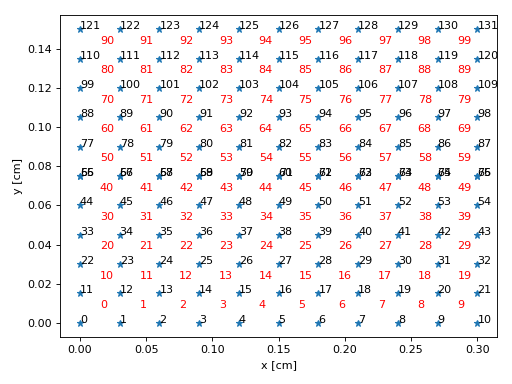

In [15]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib notebook

nelx=10
nely=10
width=0.30
heigth=0.15
nels=nelx*nely

coordx=np.linspace(0,width,nelx+1)
coordy=np.linspace(0,heigth,nely+1)
coordy=np.insert(coordy, int(nely/2)+1, heigth/2)
coord=np.zeros(((nelx+1)*(nely+2),2))
etpl=np.zeros(((nelx)*(nely),4))

# calculate coordinates of global nodes
idx=0
for j in range(nely+2):
    for i in range(nelx+1):
        coord[idx,:]=np.array([coordx[i],coordy[j]])
        idx=idx+1

# calculate connectivity matrix etpl
idx=0
etplall_bot=np.arange((1+int(nely/2))*(1+nelx)).reshape(1+int(nely/2),nelx+1)
etplall_top=np.arange((1+int(nely/2))*(1+nelx)).reshape(1+int(nely/2),nelx+1)+np.max(etplall_bot)+1
for i in range(int(nely/2)):
    for j in range(nelx):        
         etpl[idx]=np.array([etplall_bot[i,j],etplall_bot[i,j+1],etplall_bot[i+1,j+1],etplall_bot[i+1,j]])
         idx=idx+1
        
for i in range(int(nely/2)):
    for j in range(nelx):        
         etpl[idx]=np.array([etplall_top[i,j],etplall_top[i,j+1],etplall_top[i+1,j+1],etplall_top[i+1,j]])
         idx=idx+1   
etpl=etpl.astype(int)


## plot the grid:
f1=plt.figure(1)#,figsize=(9, 8))
ax1=f1.add_subplot(111)
ax1.plot(coord[:,0],coord[:,1],'*')

for node in range(len(coord[:,0])):
    ax1.annotate(str(node),(coord[node,0],coord[node,1]))
    
for el in range(len(etpl[:,0])):
    ax1.annotate(str(el),((coord[(etpl[el,0]),0]+coord[(etpl[el,1]),0])/2, \
                          (coord[(etpl[el,1]),1]+coord[(etpl[el,2]),1])/2),color='r')
    
#ax1.set_title('grid with element (red) and nodes (blue)')
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
f1.tight_layout()

## calculate the element shape functions
(for identical recangular, 4-noded elements)
In this case there are 4 shape functions (they are equal to 1):

$N1=1/4 \times (x-x2) \times (y-y4)$

$N2=-1/4  \times (x-x1) \times (y-y3)$

$N3= 1/4 \times (x-x4) \times (y-y2)$

$N4=-1/4 \times (x-x3) \times (y-y1)$

where  (x1,y1),(x2,y2),(x3,y3),(x4,y4) are the coordinates of the local nodes 0,1,2,3 of the finite element space
In our case they are equal to (-1,-1),(1,-1),(1,1),(-1,1)

## and the B matrix (derivatives of shape functions)
$B=$

\begin{vmatrix}
(y-y4)/a &0&(y3-y)/a&0&(y-y2)/a&0&(y1-y)/a&0 \\
0&(x-x2)/b&0&(x1-x)/b&0&(x-x4)/b&0&(x3-x)/b \\
(x-x2)/b&(y-y4)/a&(x1-x)/b&(y3-y)/a&(x-x4)/b&(y-y2)/a&(x3-x)/b&(y1-y)/a
\end{vmatrix}

## Build consitutive matrix D for plain stress

$D= E/(1-\nu^2) \times$
    
\begin{vmatrix}
1& \nu &0 \\
\nu & 1 &0  \\
0 & 0 & (1 - \nu)/2
\end{vmatrix}

where $E$ and $\nu$ are the Young's modulus and Poisson coefficient

In [10]:
class shape_rec:
    def __init__(self,nelx,nely,width,heigth,coord,etpl):
        self.el_width= width/nelx 
        self.el_heigth= heigth/nely
        self.gp=(1/3)**0.5*np.array([[-1,1,1,-1],[-1,-1,1,1]])
        self.x1=-1
        self.x2=1
        self.x3=1
        self.x4=-1
        self.y1=-1
        self.y2=-1
        self.y3=1
        self.y4=1 
        self.J=np.array([[(0.5*width/nelx)/1,0],[0,(0.5*heigth/nely)/1]])

    def N(self,x,y):
        n1=1/4 * (x-self.x2)*(y-self.y4)
        n2=-1/4  * (x-self.x1)*(y-self.y3)
        n3=1/4 * (x-self.x4)*(y-self.y2)    
        n4=-1/4 * (x-self.x3)*(y-self.y1)
        output=np.array([[n1,0,n2,0,n3,0,n4,0],[0,n1,0,n2,0,n3,0,n4]])
        return output
    
    def B(self,x,y):
        output= 1/4 * \
                np.array([[y-self.y4,0,self.y3-y,0, \
                           y-self.y2,0,self.y1-y,0], \
                          [0,x-self.x2,0,self.x1-x, \
                           0,x-self.x4,0,self.x3-x], \
                 [x-self.x2,y-self.y4,self.x1-x,self.y3-y, \
                  x-self.x4,y-self.y2,self.x3-x,self.y1-y]])
        output[0,:]=output[0,:]/(self.el_width/2) #(self.el_width/2) corresponds to a
        output[1,:]=output[1,:]/(self.el_heigth/2)
        output[2,::2]=output[2,::2]/(self.el_heigth/2)
        output[2,1::2]=output[2,1::2]/(self.el_width/2)
        return output

def D(E,nu):
    return E/(1-nu**2)*np.array([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])

E=3.0e9
nu=0.35

obj=shape_rec(nelx,nely,width,heigth,coord,etpl)

x=np.linspace(-1,1,10)
y=np.linspace(-1,1,10)
[X,Y]=np.meshgrid(x,y)

## Element stiffness matrix


We calculate first the element stiffness matrix for linear elasticity using (we use gaussian integration):
    
$ke = \int B^T D B dV = \Sigma_i \Sigma_j B^T D B_{ij} det(J) w_{ij}$

where

\begin{equation}
J=
\begin{vmatrix}
\frac{\partial x}{\partial \epsilon}& \frac{\partial x}{\partial \eta} \\
\frac{\partial y}{\partial \epsilon} & \frac{\partial y}{\partial \eta}
\end{vmatrix}
\end{equation}

($\epsilon$ and $\eta$ are the coordinates in the finite element space, J thus represents the ratio between the real and virtual coordinates)

## Assembly

We now sum the contribution of all the elements in a single global stiffness matrix

Each node has 2 degrees of freedom dofs (corresponding to the 2 space directions).
A dof shared between 2 neighbouring elements will have the contribution of the 2 elements in the stiffness matrix.

<IPython.core.display.Javascript object>


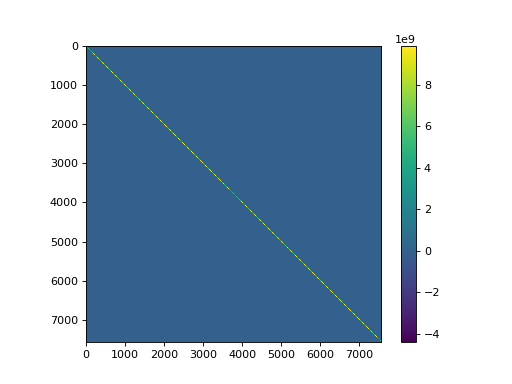

In [11]:
Det=np.linalg.det(obj.J)

ke=np.zeros((8,8))
me=np.zeros((8,8))
for gp in range(4):
    x=obj.gp[0,gp]
    y=obj.gp[1,gp]
    ke=ke+1*Det*np.matmul(np.transpose(obj.B(x,y)),np.matmul(D(E,nu),obj.B(x,y)))
    me=me+1*1200*Det*(np.transpose(obj.N(x,y))@obj.N(x,y))

K=np.zeros(((nelx+1)*(nely+2)*2,(nelx+1)*(nely+2)*2))
M=np.zeros(((nelx+1)*(nely+2)*2,(nelx+1)*(nely+2)*2))

for i in range(nels): #nels
    for row in range(4):
        for col in range(4):
            indr=etpl[i][row]*2
            indc=etpl[i][col]*2
            K[indr:(indr+2),indc:(indc+2)]=K[indr:(indr+2),indc:(indc+2)]+ke[row*2:(row*2+2),col*2:(col*2+2)]
            M[indr:(indr+2),indc:(indc+2)]=M[indr:(indr+2),indc:(indc+2)]+me[row*2:(row*2+2),col*2:(col*2+2)]
            #to check possibly...

 
f3=plt.figure(3)
ax3=f3.add_subplot(111)
im=ax3.imshow(K)

f3.colorbar(im, ax=ax3)

## New terms to add at the interface for the discontinuous galerkin method

Test with springs:

nodes to connect: int_bot and int_top

<IPython.core.display.Javascript object>


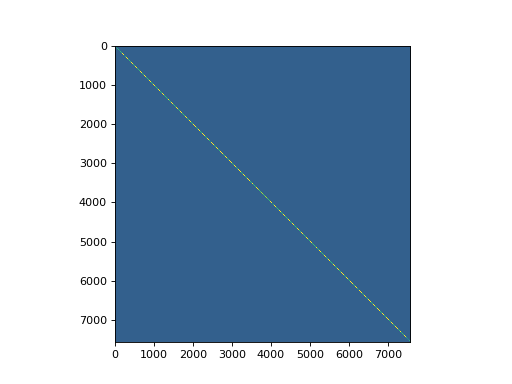

In [12]:
p=10*E/(obj.el_width*(1-nu**2))
## test with springs
int_nodes=np.where(coord[:,1]==(heigth/2))[0]
int_bot=int_nodes[0:nelx+1]
int_top=int_nodes[nelx+1:]
dofs_nodes=np.append(int_nodes*2,int_nodes*2+1)
dofs_bot=np.append(int_bot*2,int_bot*2+1)
dofs_top=np.append(int_top*2,int_top*2+1)
k_spring=3*10**9
for i in dofs_nodes:
    K[i,i]=K[i,i]+k_spring
    
for i,j in zip(dofs_bot,dofs_top):
    K[i,j]=K[i,j]-k_spring
    K[j,i]=K[j,i]-k_spring

%matplotlib notebook
f32=plt.figure(32)
ax32=f32.add_subplot(111)
ax32.imshow(K)


## Or real DG terms (see intro PDF)

<IPython.core.display.Javascript object>


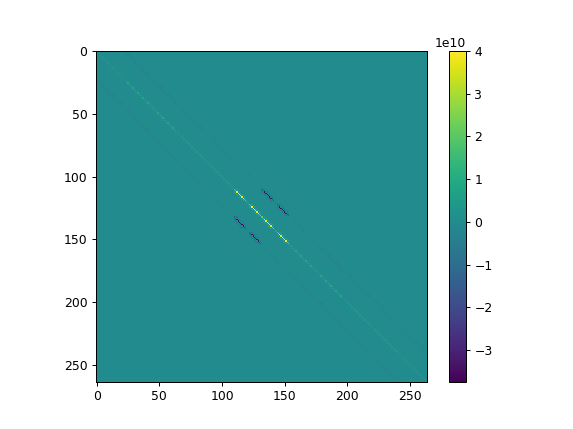

In [5]:
#assuming positive element at bottom and negative element at top, and that the normal is always vertical in the 1st place:

n=np.array([[0,0,1],[0,1,0]])


Det=obj.el_width/2

gp_surf=np.array([-(3/5)**0.5,0,(3/5)**0.5])
wgp_surf=np.array([5/9,8/9,5/9])

c1=np.zeros((8,8))
c2=np.zeros((8,8))
c3=np.zeros((8,8))
c4=np.zeros((8,8))

for gp in range(3):
    x=gp_surf[gp]
    wgt=wgp_surf[gp]
    c1=c1-wgt*Det*(np.transpose(obj.B(x,1))@(D(E,nu)@(np.transpose(n)@obj.N(x,1))))/2 \
         -wgt*Det*(np.transpose(obj.N(x,1))@(n@(D(E,nu)@obj.B(x,1))))/2 \
         + p*Det*(np.transpose(obj.N(x,1))@obj.N(x,1))
    c2=c2+wgt*Det*(np.transpose(obj.B(x,1))@(D(E,nu)@(np.transpose(n)@obj.N(x,-1))))/2 \
         -wgt*Det*(np.transpose(obj.N(x,1))@(n@(D(E,nu)@obj.B(x,-1))))/2 \
         - p*Det*(np.transpose(obj.N(x,1))@obj.N(x,-1))
    c3=c3-wgt*Det*(np.transpose(obj.B(x,-1))@(D(E,nu)@(np.transpose(n)@obj.N(x,1))))/2 \
         +wgt*Det*(np.transpose(obj.N(x,-1))@(n@(D(E,nu)@obj.B(x,1))))/2 \
         - p*Det*(np.transpose(obj.N(x,-1))@obj.N(x,1))
    c4=c4+wgt*Det*(np.transpose(obj.B(x,-1))@(D(E,nu)@(np.transpose(n)@obj.N(x,-1))))/2 \
         +wgt*Det*(np.transpose(obj.N(x,-1))@(n@(D(E,nu)@obj.B(x,-1))))/2 \
         + p*Det*(np.transpose(obj.N(x,-1))@obj.N(x,-1))

    
##Determine which face terms we want to calculate (all of them if no crack)
etpl_face=np.array([range(int(nels/2)-nelx,int(nels/2)), \
               range(int(nels/2),int(nels/2)+nelx)]) #positives and negative elements
halfcrackwidth=0.04
mid_coord_face=(coord[etpl[etpl_face[0,:],0],0]+coord[etpl[etpl_face[0,:],1],0])/2
ind_crack=np.where(np.logical_or(mid_coord_face<width/2-halfcrackwidth,mid_coord_face>width/2+halfcrackwidth))
etpl_face2=etpl_face[:,ind_crack[0]]


## Assembly of the face terms, in a similar way than the continuous part:

for i,j in zip(etpl_face2[0,:],etpl_face2[1,:]): # 1 iteration per face
    for row in range(4):
        for col in range(4):
            indr_1=etpl[i][row]*2
            indc_1=etpl[i][col]*2
            indr_4=etpl[j][row]*2
            indc_4=etpl[j][col]*2
            K[indr_1:(indr_1+2),indc_1:(indc_1+2)]=K[indr_1:(indr_1+2),indc_1:(indc_1+2)]+c1[row*2:(row*2+2),col*2:(col*2+2)]
            K[indr_1:(indr_1+2),indc_4:(indc_4+2)]=K[indr_1:(indr_1+2),indc_4:(indc_4+2)]+c2[row*2:(row*2+2),col*2:(col*2+2)]
            K[indr_4:(indr_4+2),indc_1:(indc_1+2)]=K[indr_4:(indr_4+2),indc_1:(indc_1+2)]+c3[row*2:(row*2+2),col*2:(col*2+2)]
            K[indr_4:(indr_4+2),indc_4:(indc_4+2)]=K[indr_4:(indr_4+2),indc_4:(indc_4+2)]+c4[row*2:(row*2+2),col*2:(col*2+2)]
            
f33=plt.figure(33)
ax33=f33.add_subplot(111)
im3=ax33.imshow(K)
f33.colorbar(im3, ax=ax33)

## Now we need to assemble the surface terms

## Apply boundary conditions and solve the static system

We can apply dispacements or force boundaries at chosen dofs (by default a force = 0 is applied)

To apply a force to a dof, we just need to add this force to the force vector

To apply a displacement $d_i$, we have to modify the stiffness matrix $K$ and the force vector $F$ so that:

$u_i = d_i$


<IPython.core.display.Javascript object>


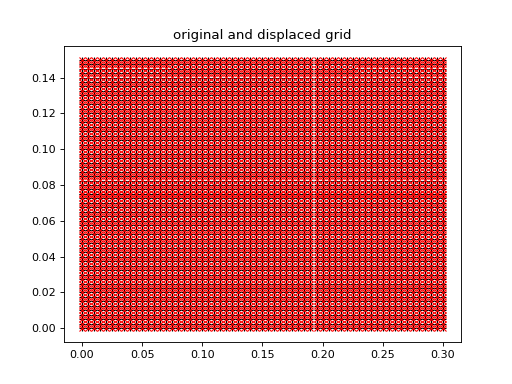

In [13]:
F=np.zeros(((nelx+1)*(nely+2)*2,1))
free_nodes=np.where(coord[:,1]>0)[0]
free_dofs=np.append(free_nodes*2,free_nodes*2+1)
fixed_nodes=np.where(coord[:,1]==0)[0]
fixed_dofs=np.append(fixed_nodes*2,fixed_nodes*2+1)

nmn_nodes=np.where(coord[:,1]==heigth)[0]
#nmn_dofs=np.append(nmn_nodes*2,nmn_nodes*2+1)
nmn_dofs=nmn_nodes*2+1  # +1 for y direction +0 for pure x direction
elem_surf=width/nelx #check if we have to multiply by thickness of plate
P=1.0e6 # there is a factor 4 of difference between applied and result (not exactly)
force=P*elem_surf
F[nmn_dofs]=force

d=0.0;
for id in range(len(fixed_dofs)):
    i=fixed_dofs[id];
    rows=K[free_dofs,i];
    F[free_dofs,0]=F[free_dofs,0]-rows*d;
    # maybe we can delete the lines where the calculation is trivial
    # or at least make the matrix sparse
    K[:,i]=0;
    K[i,:]=0;
    K[i,i]=1;
    F[i]=d;

    
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
Ksp = csr_matrix(K)
U= spsolve(Ksp,F)
#U= np.linalg.solve(K,F) # without sparsing K

# # # To plot the displaced nodes
%matplotlib notebook
f4=plt.figure(4)
ax4=f4.add_subplot(111)
#ax3.quiver(coord[:,0],coord[:,1],U[::2],U[1::2])
ax4.plot(coord[:,0],coord[:,1],'+k')
ax4.plot(coord[:,0]+U[::2],coord[:,1]+U[1::2],'xr') #U[::2,0] if not using sparse
ax4.set_title('original and displaced grid')

## Find stresses

We use 

\begin{equation}
\begin{vmatrix}
\sigma_{xx} \\
\sigma_{yy} \\
\sigma_{xy}
\end{vmatrix} = D.
\begin{vmatrix}
\epsilon_{xx} \\
\epsilon_{yy} \\
\epsilon_{xy}
\end{vmatrix} = D.
\begin{vmatrix}
\frac{\partial Ux}{\partial x}& 0 \\
0 & \frac{\partial Uy}{\partial y}  \\
\frac{\partial Ux}{\partial y} & \frac{\partial Uy}{\partial x}
\end{vmatrix}
\end{equation}

where $U_x$ and $U_y$ are the deformation at the nodes in x and y directions. $\epsilon$ is the strain and $D$ is the linear elasticity matrix for plane stress problem.

<IPython.core.display.Javascript object>


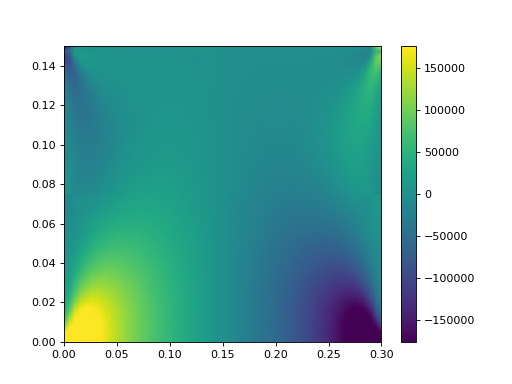

In [14]:
## plot bottom half:

sigma_b=np.zeros((int(nely/2)+1,nelx+1,3))
sigma_t=np.zeros((int(nely/2)+1,nelx+1,3))
ux_mat=U[::2].reshape((nely+2, nelx+1))
uy_mat=U[1::2].reshape((nely+2, nelx+1))
ux_mat_b=ux_mat[0:int(nely/2)+1,:]
uy_mat_b=uy_mat[0:int(nely/2)+1,:]
ux_mat_t=ux_mat[int(nely/2)+1:,:]
uy_mat_t=uy_mat[int(nely/2)+1:,:]

##botom
Dub=np.gradient(ux_mat_b,obj.el_heigth,obj.el_width); #to check width or heigth first
Dvb=np.gradient(uy_mat_b,obj.el_heigth,obj.el_width);
Dxub=Dub[1]
Dyub=Dub[0]
Dxvb=Dvb[1]
Dyvb=Dvb[0]
Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
for i in range(int(nely/2)+1):
    for j in range(nelx+1):
        strain=np.matmul(Bstress,np.array([[Dxub[i,j]],[Dyvb[i,j]],[Dxvb[i,j]],[Dyub[i,j]]]));
        stress=np.matmul(D(E,nu),strain);
        sigma_b[i,j,0]=stress[0]; # 0 for sxx
        sigma_b[i,j,1]=stress[1]; # 1 for syy
        sigma_b[i,j,2]=stress[2]; # 2 for tauxy
#top
Dut=np.gradient(ux_mat_t,obj.el_heigth,obj.el_width); #to check width or heigth first
Dvt=np.gradient(uy_mat_t,obj.el_heigth,obj.el_width);
Dxut=Dut[1]
Dyut=Dut[0]
Dxvt=Dvt[1]
Dyvt=Dvt[0]
Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
for i in range(int(nely/2)+1):
    for j in range(nelx+1):
        strain=np.matmul(Bstress,np.array([[Dxut[i,j]],[Dyvt[i,j]],[Dxvt[i,j]],[Dyut[i,j]]]));
        stress=np.matmul(D(E,nu),strain);
        sigma_t[i,j,0]=stress[0]; # 0 for sxx
        sigma_t[i,j,1]=stress[1]; # 1 for syy
        sigma_t[i,j,2]=stress[2]; # 2 for tauxy

        
%matplotlib notebook
f5=plt.figure(5)
ax5=f5.add_subplot(111)
stressmap1=ax5.pcolormesh(((coord[:,0]+U[::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:], \
                      ((coord[:,1]+U[1::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:], \
                      sigma_b[:,:,2], shading='Gouraud')

stressmap2=ax5.pcolormesh(((coord[:,0]+U[::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:], \
                      ((coord[:,1]+U[1::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:], \
                      sigma_t[:,:,2], shading='Gouraud')

#ax5.set_aspect('equal')

stressmap1.set_clim(np.min(sigma_t[:,:,2]),np.max(sigma_t[:,:,2]))
stressmap2.set_clim(np.min(sigma_t[:,:,2]),np.max(sigma_t[:,:,2]))
# Visualizing colorbar part -start
f5.colorbar(stressmap1,ax=ax5)
# fig.colorbar(mesh1,ax=ax1)